In [34]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import linalg
from scipy import stats
from IPython.display import HTML, display


plt.rcdefaults()

In [4]:
emails = pd.read_csv(r"C:\Users\AALEKH\Downloads\spam.csv", encoding="iso8859-1")
emails[['v1','v2']].head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate a count vectorizer
vect = CountVectorizer(analyzer="word")
# obtain vocabulary dictionary and return doc-term matrix
X = vect.fit_transform(emails.v2) 
# get the identified terms
terms = vect.get_feature_names()
# sum terms' frequencies in the entire collection
freqs = X.toarray().sum(axis=0)
terms = np.array(terms)
freqs = np.array(freqs)

# organize the tersm and frequencies in t and f columns
tfs = pd.DataFrame({'t':terms, 'f':freqs}, columns=['t','f'])


In [4]:
tfs = tfs.sort_values(by=['f'], ascending=False)
tfs = tfs.reset_index(drop=True)
tfs.head()

,t,f
0,to,2242
1,you,2240
2,the,1328
3,and,979
4,in,898


In [5]:
tfs['k'] = tfs.index + 1
tfs[['t','k','f']].head()

,t,k,f
0,to,1,2242
1,you,2,2240
2,the,3,1328
3,and,4,979
4,in,5,898


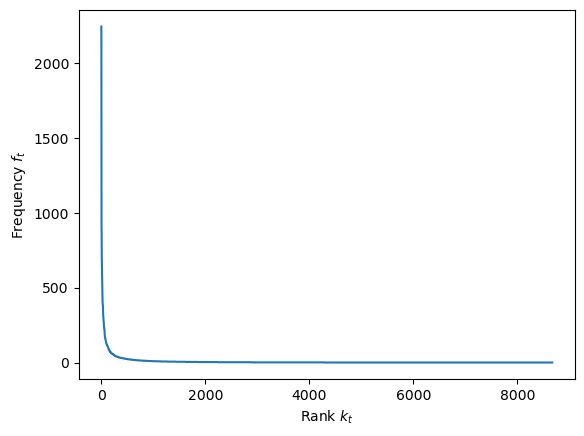

In [6]:
plt.plot(tfs['k'], tfs['f'])
plt.xlabel('Rank $k_t$')
plt.ylabel('Frequency $f_t$')
plt.show()

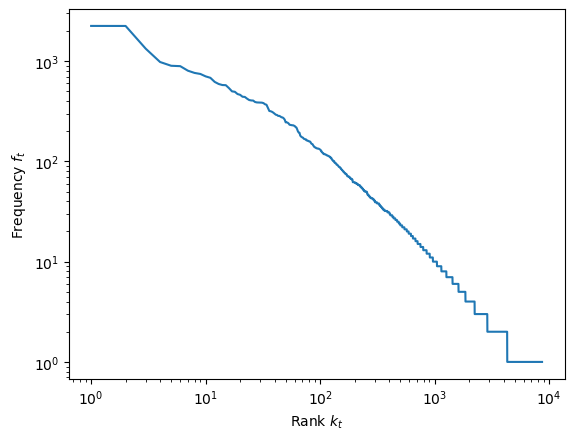

In [7]:
plt.loglog(tfs['k'], tfs['f'])
plt.xlabel('Rank $k_t$')
plt.ylabel('Frequency $f_t$')
plt.show()

In [8]:
ttf = tfs['f'].sum()
tfs['p'] = tfs['f'] / ttf
tfs[['t','k','p']].head()

,t,k,p
0,to,1,0.027971
1,you,2,0.027946
2,the,3,0.016568
3,and,4,0.012214
4,in,5,0.011203


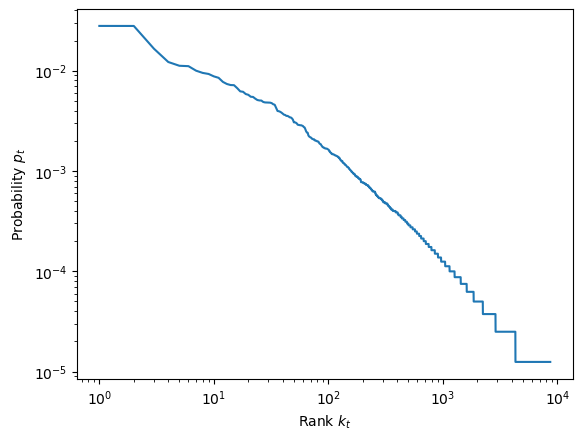

In [9]:
plt.loglog(tfs['k'], tfs['p'])
plt.xlabel('Rank $k_t$')
plt.ylabel('Probability $p_t$')
plt.show()

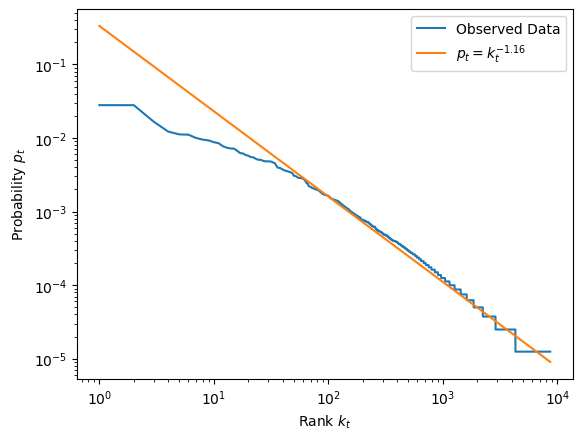

In [10]:
from sklearn.linear_model import LinearRegression

# log transformation of k and p values
x = tfs['k'].values.reshape(-1,1)
xlog = np.log(x)
y = tfs['p'].values.reshape(-1,1)
ylog = np.log(y)

# perform linear regression on log values
lm = LinearRegression()
lm.fit(xlog,ylog)
yplog = lm.predict(xlog)

# plot the fitted (predicted) line 
# along with actual k_t and p_t data
plt.loglog(tfs['k'], tfs['p'], label="Observed Data")
plt.loglog(x, np.exp(yplog), 
           label="$p_t = k_t^{" + "{:.2f}".format(lm.coef_[0][0]) + "}$")
plt.xlabel('Rank $k_t$')
plt.ylabel('Probability $p_t$')
plt.legend()
plt.show()

In [11]:
train_index = np.random.rand(len(emails)) < 0.8
print(train_index)

[ True False  True ...  True False  True]


In [12]:
train = emails[train_index]
test = emails[~train_index]

In [13]:
n = train.shape[0]
counts = train.groupby("v1")["v1"].value_counts()
print(counts)
ham = counts[0]
# compute probability
p_ham = ham / n
print("p(ham) = {:.3f}".format(p_ham))

v1    v1  
ham   ham     3833
spam  spam     609
Name: v1, dtype: int64
p(ham) = 0.863


In [14]:
# get the total number of spams
spam = counts[1]
# compute probability
p_spam = spam / n
print("p(spam) = {:.3f}".format(p_spam))

p(spam) = 0.137


In [15]:
vect = CountVectorizer(analyzer="word")
X_train = vect.fit_transform(train.v2)
X_test = vect.transform(test.v2)
ham_index = train['v1']=='ham'
hams = train[ham_index]
spams = train[~ham_index]
X_hams = vect.transform(hams.v2)
X_spams = vect.transform(spams.v2)
X_hams.shape

(3833, 7782)

In [16]:
terms = vect.get_feature_names()
t = "prize"
i = terms.index(t)
print("The {:d}th term is: {:s}".format(i, t))

The 5435th term is: prize


In [17]:
hamf = X_hams.toarray().sum(axis=0)
hamttf = hamf.sum()
f = hamf[i]
p = f / hamttf
ps = (f+1)/(hamttf+2)
print("p({:s}|ham) = {:.7f}, smoothed to {:.7f}".format(t, p, ps))

p(prize|ham) = 0.0000000, smoothed to 0.0000202


In [18]:
terms = vect.get_feature_names()
spamf = X_spams.toarray().sum(axis=0)
spamttf = spamf.sum()
f = spamf[i]
p = f / hamttf
ps = (f+1)/(spamttf+2)
print("p({:s}|spam) = {:.7f}, smoothed to {:.7f}".format(t, p, ps))

p(prize|spam) = 0.0013711, smoothed to 0.0048688


In [19]:
t1 = terms.index("prize")
t2 = terms.index("meeting")
t1, t2

(5435, 4443)

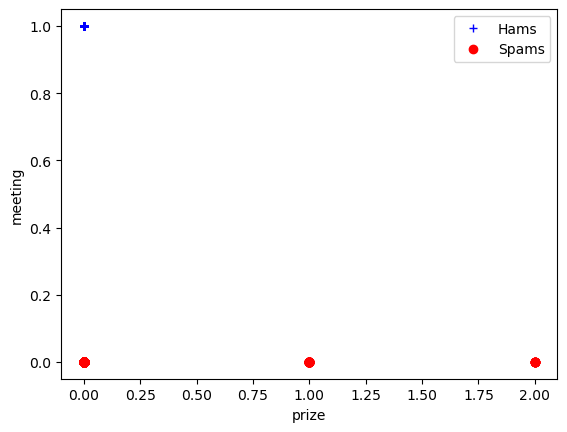

In [20]:
# Example to plot two term (column vectors) on x and y
plt.plot(X_hams.toarray()[:,t1], X_hams.toarray()[:,t2], '+', color="blue", label="Hams")
plt.plot(X_spams.toarray()[:,t1], X_spams.toarray()[:,t2], 'o', color="red", label="Spams")
plt.xlabel("prize")
plt.ylabel("meeting")
plt.legend()

In [22]:
from sklearn.naive_bayes import BernoulliNB

# build the Bernoulli Naive Bayes classifiers
# with parameters, such as: 
# 1. alpha value for the Laplace estimator (smoothing)
# 2. binarize, the threshold/cutoff for 0 or 1 values
bNB = BernoulliNB(alpha=.01, binarize=0.0)
bNB.fit(X_train, train.v1)
v1p = bNB.predict(X_test)


In [23]:
print(v1p)

['ham' 'ham' 'spam' ... 'ham' 'spam' 'ham']


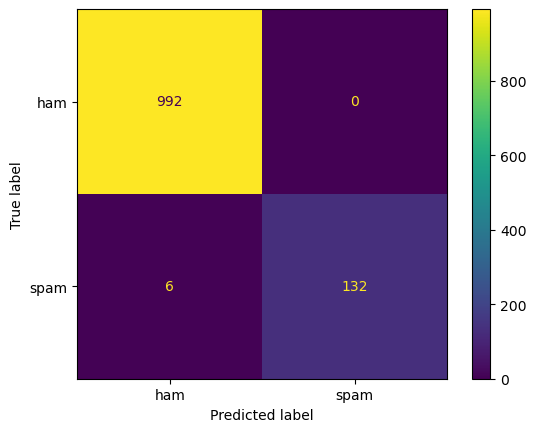

In [24]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(v1p, test.v1)
display(plot_confusion_matrix(bNB, X_test, test.v1, values_format='d'))

In [25]:
from sklearn.metrics import accuracy_score, cohen_kappa_score 
acc = accuracy_score(v1p, test.v1)
kappa = cohen_kappa_score(v1p, test.v1)

print("Accuracy: {:.4f}".format(acc))
print("Kappa   : {:.4f}".format(kappa))

Accuracy: 0.9947
Kappa   : 0.9748


In [27]:
from sklearn.metrics import classification_report
print(classification_report(v1p,test.v1))

              precision    recall  f1-score   support

         ham       1.00      0.99      1.00       998
        spam       0.96      1.00      0.98       132

    accuracy                           0.99      1130
   macro avg       0.98      1.00      0.99      1130
weighted avg       0.99      0.99      0.99      1130



In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# instantiate a Tfidf vectorizer
vect = TfidfVectorizer(analyzer="word")
# obtain vocabulary dictionary and return doc-term matrix
X = vect.fit_transform(emails.v2) 
# get the identified terms
terms = vect.get_feature_names()
# sum terms' frequencies in the entire collection
freqs = X.toarray().sum(axis=0)
terms = np.array(terms)
freqs = np.array(freqs)

# organize the tersm and frequencies in t and f columns
tfs = pd.DataFrame({'t':terms, 'f':freqs}, columns=['t','f'])


In [6]:
tfs = tfs.sort_values(by=['f'], ascending=False)
tfs = tfs.reset_index(drop=True)
tfs.head()

,t,f
0,you,245.978616
1,to,205.865267
2,the,147.009403
3,in,122.283484
4,me,117.899742


In [7]:
tfs['k'] = tfs.index + 1
tfs[['t','k','f']].head()

,t,k,f
0,you,1,245.978616
1,to,2,205.865267
2,the,3,147.009403
3,in,4,122.283484
4,me,5,117.899742


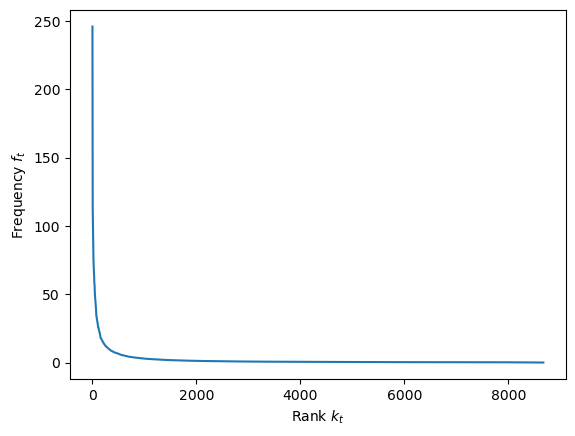

In [8]:
plt.plot(tfs['k'], tfs['f'])
plt.xlabel('Rank $k_t$')
plt.ylabel('Frequency $f_t$')
plt.show()

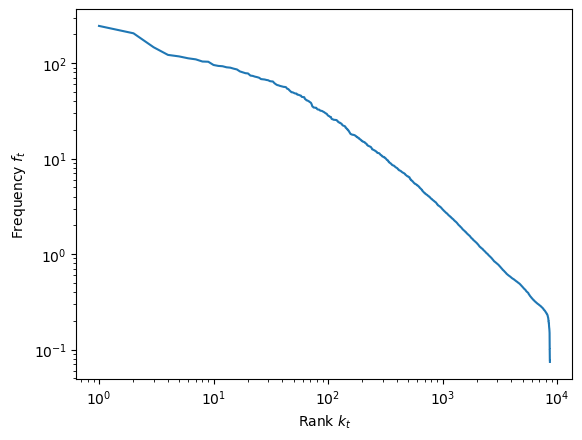

In [9]:
plt.loglog(tfs['k'], tfs['f'])
plt.xlabel('Rank $k_t$')
plt.ylabel('Frequency $f_t$')
plt.show()

In [11]:
ttf = tfs['f'].sum()
tfs['p'] = tfs['f'] / ttf
tfs[['t','k','p']].head()

,t,k,p
0,you,1,0.013514
1,to,2,0.011310
2,the,3,0.008077
3,in,4,0.006718
4,me,5,0.006477


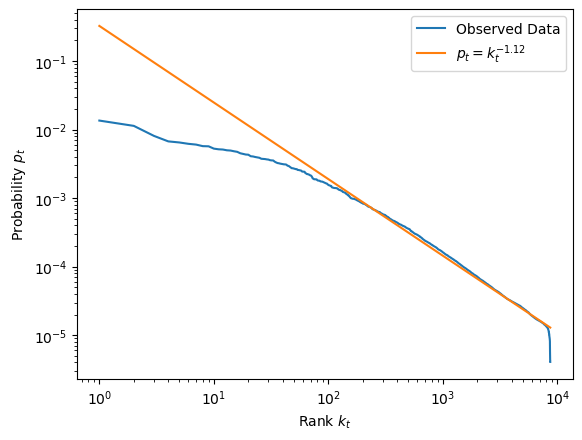

In [12]:
from sklearn.linear_model import LinearRegression

# log transformation of k and p values
x = tfs['k'].values.reshape(-1,1)
xlog = np.log(x)
y = tfs['p'].values.reshape(-1,1)
ylog = np.log(y)

# perform linear regression on log values
lm = LinearRegression()
lm.fit(xlog,ylog)
yplog = lm.predict(xlog)

# plot the fitted (predicted) line 
# along with actual k_t and p_t data
plt.loglog(tfs['k'], tfs['p'], label="Observed Data")
plt.loglog(x, np.exp(yplog), 
           label="$p_t = k_t^{" + "{:.2f}".format(lm.coef_[0][0]) + "}$")
plt.xlabel('Rank $k_t$')
plt.ylabel('Probability $p_t$')
plt.legend()
plt.show()

In [13]:
train_index = np.random.rand(len(emails)) < 0.8
print(train_index)

[ True  True  True ...  True  True False]


In [14]:
train = emails[train_index]
test = emails[~train_index]

In [15]:
n = train.shape[0]
counts = train.groupby("v1")["v1"].value_counts()
print(counts)
ham = counts[0]
# compute probability
p_ham = ham / n
print("p(ham) = {:.3f}".format(p_ham))

v1    v1  
ham   ham     3834
spam  spam     588
Name: v1, dtype: int64
p(ham) = 0.867


In [16]:
# get the total number of spams
spam = counts[1]
# compute probability
p_spam = spam / n
print("p(spam) = {:.3f}".format(p_spam))

p(spam) = 0.133


In [33]:
vect = TfidfVectorizer(analyzer="word")
X_train = vect.fit_transform(train.v2)
X_test = vect.transform(test.v2)
ham_index = train['v1']=='ham'
hams = train[ham_index]
spams = train[~ham_index]
X_hams = vect.transform(hams.v2)
X_spams = vect.transform(spams.v2)
X_hams.shape

(3834, 7648)

In [18]:
terms = vect.get_feature_names()
t = "prize"
i = terms.index(t)
print("The {:d}th term is: {:s}".format(i, t))

The 5360th term is: prize


In [19]:
hamf = X_hams.toarray().sum(axis=0)
hamttf = hamf.sum()
f = hamf[i]
p = f / hamttf
ps = (f+1)/(hamttf+2)
print("p({:s}|ham) = {:.7f}, smoothed to {:.7f}".format(t, p, ps))

p(prize|ham) = 0.0000000, smoothed to 0.0000843


In [20]:
terms = vect.get_feature_names()
spamf = X_spams.toarray().sum(axis=0)
spamttf = spamf.sum()
f = spamf[i]
p = f / hamttf
ps = (f+1)/(spamttf+2)
print("p({:s}|spam) = {:.7f}, smoothed to {:.7f}".format(t, p, ps))

p(prize|spam) = 0.0012724, smoothed to 0.0062556


In [21]:
t1 = terms.index("prize")
t2 = terms.index("meeting")
t1, t2

(5360, 4379)

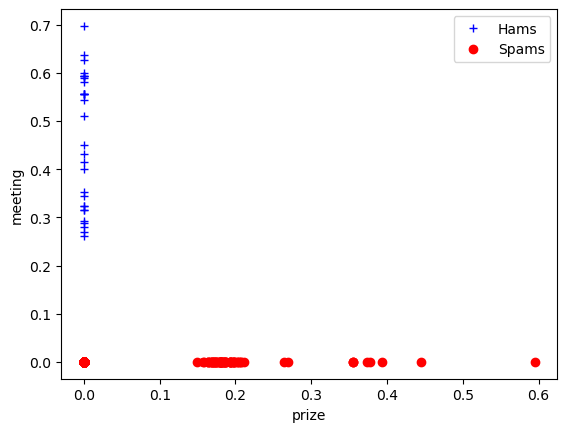

In [22]:
# Example to plot two term (column vectors) on x and y
plt.plot(X_hams.toarray()[:,t1], X_hams.toarray()[:,t2], '+', color="blue", label="Hams")
plt.plot(X_spams.toarray()[:,t1], X_spams.toarray()[:,t2], 'o', color="red", label="Spams")
plt.xlabel("prize")
plt.ylabel("meeting")
plt.legend()

In [23]:
from sklearn.naive_bayes import BernoulliNB

# build the Bernoulli Naive Bayes classifiers
# with parameters, such as: 
# 1. alpha value for the Laplace estimator (smoothing)
# 2. binarize, the threshold/cutoff for 0 or 1 values
bNB = BernoulliNB(alpha=.01, binarize=0.0)
bNB.fit(X_train, train.v1)
v1p = bNB.predict(X_test)

In [24]:
print(v1p)

['ham' 'ham' 'ham' ... 'ham' 'ham' 'ham']


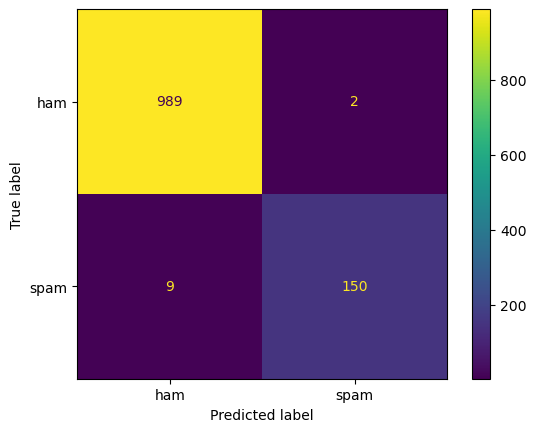

In [25]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(v1p, test.v1)
display(plot_confusion_matrix(bNB, X_test, test.v1, values_format='d'))

In [26]:
from sklearn.metrics import accuracy_score, cohen_kappa_score 
acc = accuracy_score(v1p, test.v1)
kappa = cohen_kappa_score(v1p, test.v1)

print("Accuracy: {:.4f}".format(acc))
print("Kappa   : {:.4f}".format(kappa))

Accuracy: 0.9904
Kappa   : 0.9591


In [27]:
from sklearn.metrics import classification_report
print(classification_report(v1p,test.v1))

              precision    recall  f1-score   support

         ham       1.00      0.99      0.99       998
        spam       0.94      0.99      0.96       152

    accuracy                           0.99      1150
   macro avg       0.97      0.99      0.98      1150
weighted avg       0.99      0.99      0.99      1150

